This notebook assumes you are using sims_maf version >= 1.1, and have 'setup sims_maf' in your shell. 

#Demonstrate the proper motion and parallax metrics.#

For both of these metrics, visits in all bands are used (unless restricted by the user via a sqlconstraint). 
The astrometric error for each visit, for a star of the specified brightness and spectral type, is estimated from the magnitude of the star and the m5 limit of each visit (recorded by opsim). 
The parallax error is estimated by assuming that the proper motion is perfectly fit (or zero); the proper motion error is likewise estimated by assuming the parallax is perfectly fit (or zero). 
In both cases, the effects of refraction is not currently included in the astrometric error. 

Here is a link to the [code](https://github.com/lsst/sims_maf/blob/master/python/lsst/sims/maf/metrics/calibrationMetrics.py) for the proper motion and parallax metrics. 
The 'ra_pi_amp' and 'dec_pi_amp' columns referred to in the parallax metric are stacker columns which calculate the parallax amplitude (in ra and dec) for each visit, using this [code](https://github.com/lsst/sims_maf/blob/master/python/lsst/sims/maf/stackers/generalStackers.py). 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
# Set up the database connection
# Database available from: http://astro-lsst-01.astro.washington.edu:8081/db_gzip/baseline2018a.db.gz
opsdb = db.OpsimDatabase('baseline2018a.db')
outDir = 'astrometry_test'
resultsDb = db.ResultsDb(outDir=outDir)

Define our basic sqlconstraint (we'll only look at the first three years here) and define the metrics and slicer. 

In [3]:
sql = 'night < %i' % (365.25*3) # See How well we do after year 3
slicer = slicers.HealpixSlicer(nside=64)
metricList = []
metricList.append(metrics.ParallaxMetric())
metricList.append(metrics.ParallaxMetric(metricName='parallax Normed', normalize=True))
metricList.append(metrics.ProperMotionMetric())
metricList.append(metrics.ProperMotionMetric(metricName='properMotion Normed', normalize=True))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Add a summary metric to compute for each of the metricBundles. 

In [4]:
summaryList = [metrics.MedianMetric()]

In [5]:
bundleList = []
plotDict = {'percentileClip': 95.}
for metric in metricList:
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, summaryMetrics=summaryList,
                                                plotDict=plotDict))

In [6]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint night < 1095 for columns ['filter', 'fiveSigmaDepth', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'fieldRA']
Found 696705 visits
Running:  ['opsim_parallax_night_lt_1095_HEAL', 'opsim_parallax_Normed_night_lt_1095_HEAL', 'opsim_properMotion_night_lt_1095_HEAL', 'opsim_properMotion_Normed_night_lt_1095_HEAL']


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/metrics/calibrationMetrics.py:85: RuntimeWarning: divide by zero encountered in true_divide
  sigma_B = position_errors/dec_pi_amp
/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/metrics/calibrationMetrics.py:87: RuntimeWarning: divide by zero encountered in double_scalars
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "night < 1095" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 353 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 1.5777  dipole: lon: -61.2462, lat: 78.2909, amp: 0.573175
monopole: 0.697317  dipole: lon: 97.2918, lat: -70.8055, amp: 0.187101


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 453 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 1.29676  dipole: lon: 104.53, lat: 88.7282, amp: 0.223329


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 239 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.172405  dipole: lon: -27.9512, lat: -29.1325, amp: 0.00618786
Plotting complete.


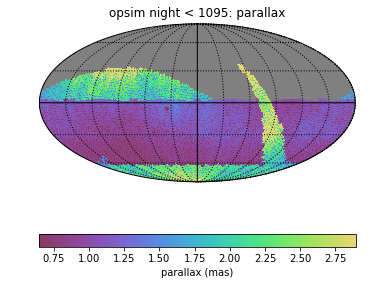

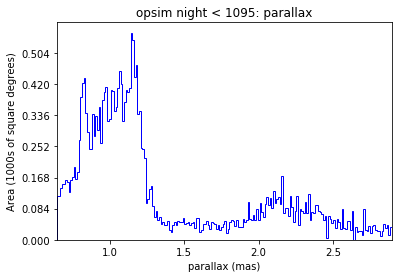

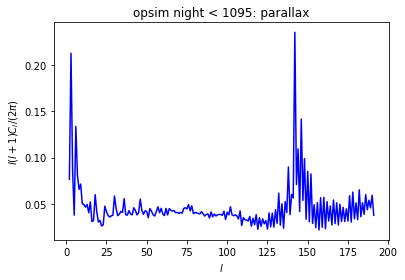

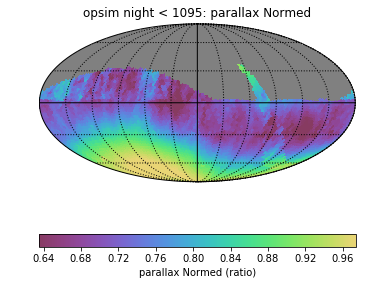

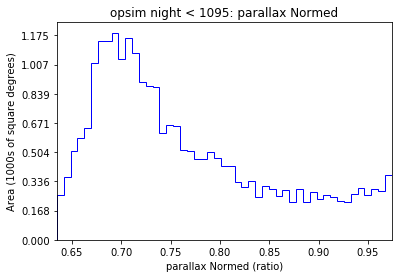

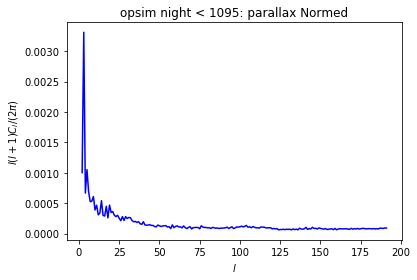

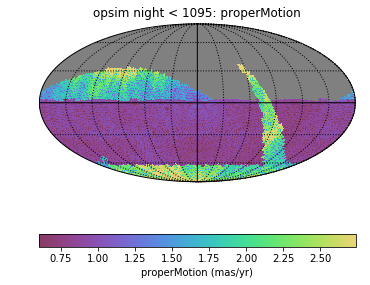

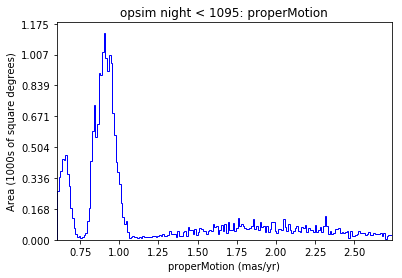

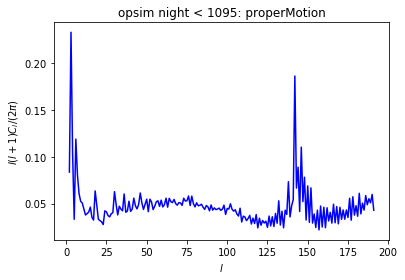

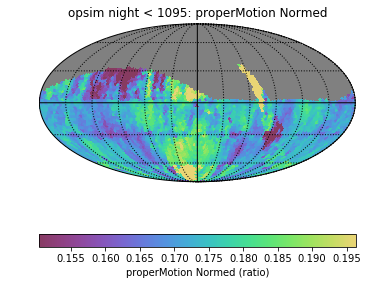

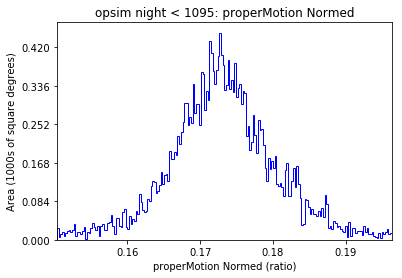

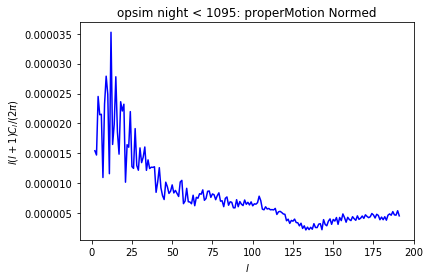

In [7]:
bgroup.plotAll(closefigs=False)

By default, the proper motion and parallax metrics assume a flat SED with an r-band magnitude of 20, however this can be specified by the user when setting up the metric.

In [10]:
rmags = {'faint':25, 'bright':18}
specTypes = ['B', 'K']
metricList = []
plotDict = {'percentileClip': 95.}
for mag in rmags:
    for specType in specTypes:
        metricList.append(metrics.ParallaxMetric(rmag=rmags[mag], SedTemplate=specType, 
                                                 metricName='parallax_'+mag+'_'+specType))
        metricList.append(metrics.ProperMotionMetric(rmag=rmags[mag], SedTemplate=specType, 
                                                     metricName='properMotion'+mag+'_'+specType))

In [11]:
bundlesSpec = []
for metric in metricList:
    bundlesSpec.append(metricBundles.MetricBundle(metric,slicer,sql, summaryMetrics=summaryList,
                                                plotDict=plotDict))
bundlesSpec = metricBundles.makeBundlesDictFromList(bundlesSpec)

In [12]:
bgroup = metricBundles.MetricBundleGroup(bundlesSpec, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint night < 1095 for columns ['filter', 'fiveSigmaDepth', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'fieldRA']
Found 696705 visits
Running:  ['opsim_parallax_faint_B_night_lt_1095_HEAL', 'opsim_properMotionfaint_B_night_lt_1095_HEAL', 'opsim_parallax_faint_K_night_lt_1095_HEAL', 'opsim_properMotionfaint_K_night_lt_1095_HEAL', 'opsim_parallax_bright_B_night_lt_1095_HEAL', 'opsim_properMotionbright_B_night_lt_1095_HEAL', 'opsim_parallax_bright_K_night_lt_1095_HEAL', 'opsim_properMotionbright_K_night_lt_1095_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "night < 1095" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 1926 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 53.6426  dipole: lon: -29.8589, lat: 81.2677, amp: 39.6293


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 3170 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 46.7224  dipole: lon: -20.4969, lat: 79.975, amp: 29.1539


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 602 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 65.0765  dipole: lon: -36.8555, lat: 77.8052, amp: 37.3139


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 750 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 53.3817  dipole: lon: -4.37365, lat: 70.7551, amp: 19.0271
monopole: 1.2358  dipole: lon: -63.6344, lat: 79.5127, amp: 0.400736


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 226 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 1.02141  dipole: lon: 146.304, lat: 76.2932, amp: 0.134757


/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


monopole: 1.18534  dipole: lon: -62.4201, lat: 78.4087, amp: 0.366979


/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


monopole: 0.979108  dipole: lon: 140.71, lat: 72.0944, amp: 0.0987392
Plotting complete.


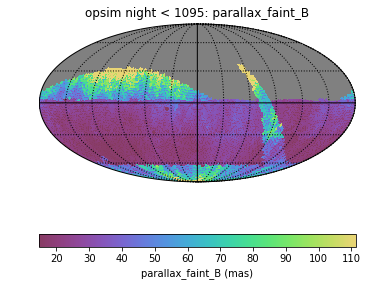

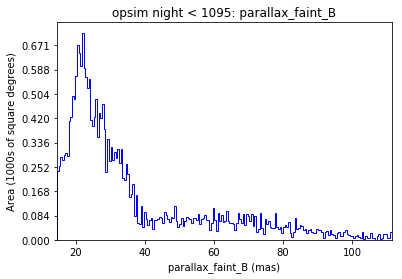

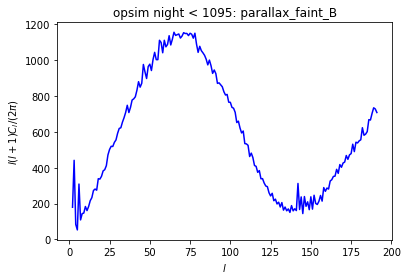

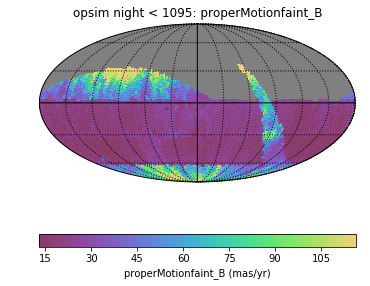

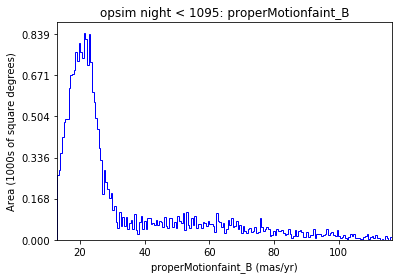

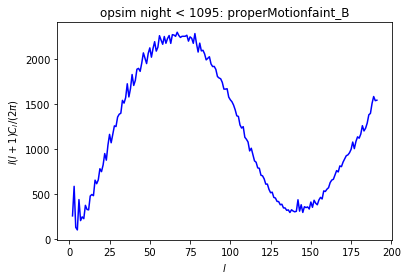

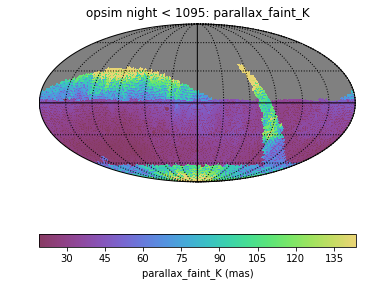

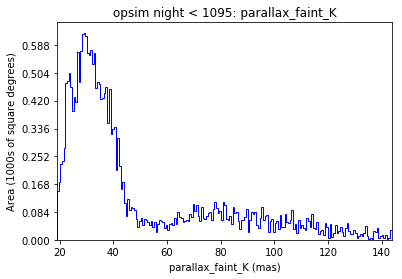

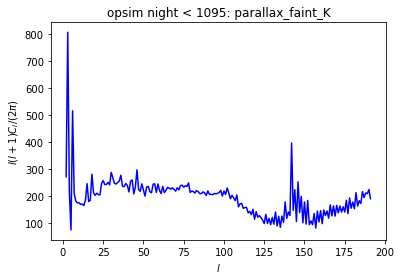

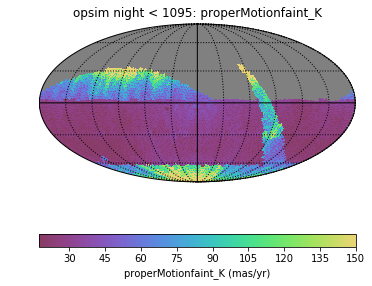

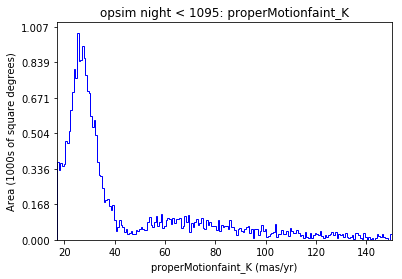

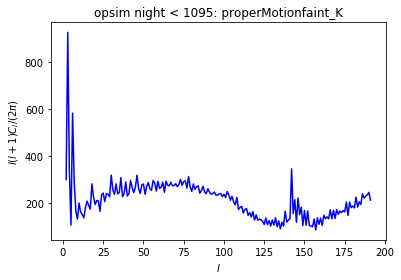

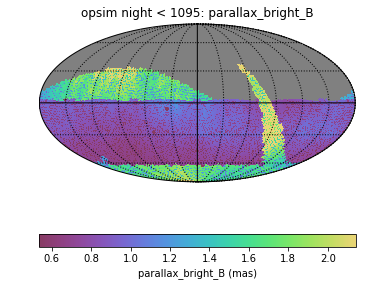

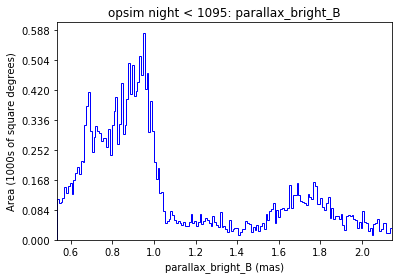

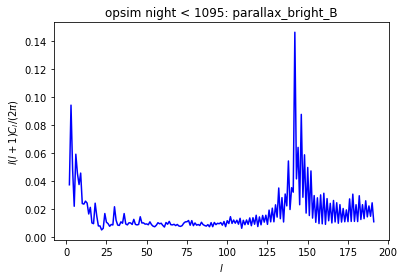

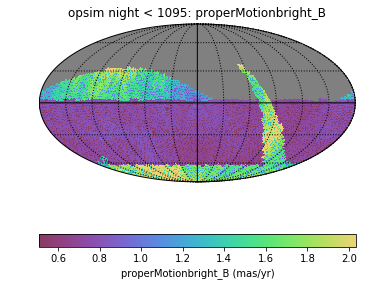

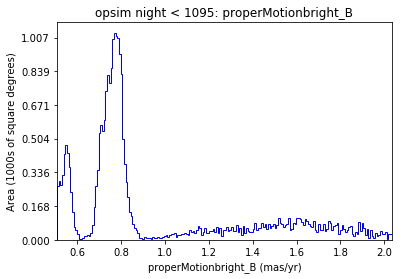

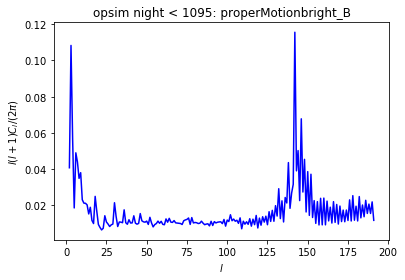

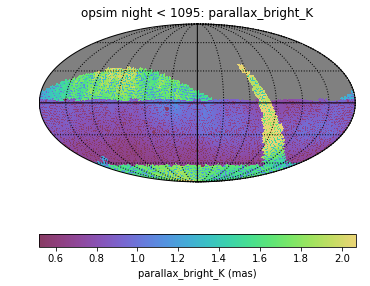

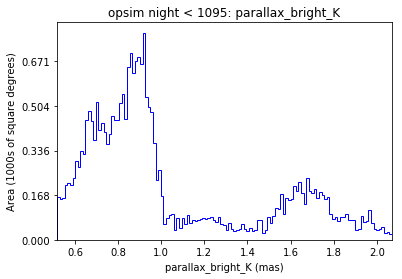

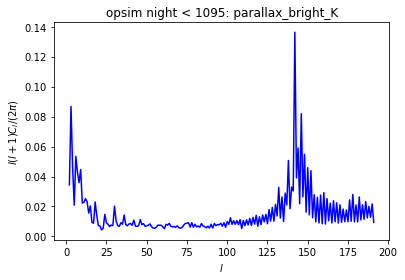

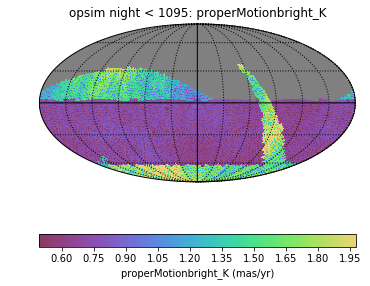

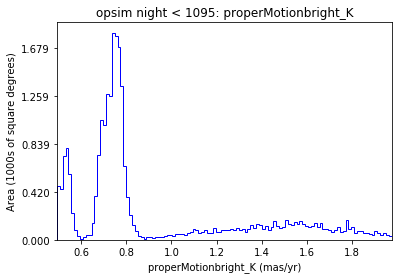

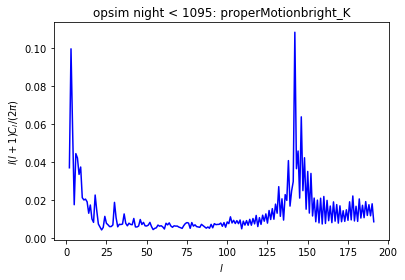

In [13]:
bgroup.plotAll(closefigs=False)

In [14]:
print('Flat SED:')
for bundle in bundleList:
    print(bundle.metric.name, bundle.summaryValues)
print('B and K stars:')
for bundle in bundlesSpec:
    print(bundlesSpec[bundle].metric.name, bundlesSpec[bundle].summaryValues)

Flat SED:
parallax {'Median': 1.1205172953865949}
parallax Normed {'Median': 0.73526281038490993}
properMotion {'Median': 0.93208904119636315}
properMotion Normed {'Median': 0.17288143229954442}
B and K stars:
parallax_faint_B {'Median': 27.929436281538997}
properMotionfaint_B {'Median': 23.141520928258718}
parallax_faint_K {'Median': 35.949074279472768}
properMotionfaint_K {'Median': 30.111151359989581}
parallax_bright_B {'Median': 0.92410426523842293}
properMotionbright_B {'Median': 0.77791633783101355}
parallax_bright_K {'Median': 0.88986200090022116}
properMotionbright_K {'Median': 0.75686566854465209}
